In [1]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
import pyemma
feat = pyemma.coordinates.featurizer(trajs[0].top)
feat.add_backbone_torsions()
feat.describe()

['PHI 0 ALA 2', 'PSI 0 ALA 2']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X = [feat.transform(traj) for traj in trajs]

# which of these states should we choose as milestones?
np.random.seed(0)
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X, k=1000, max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

21-09-16 08:21:46 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 530 steps.


In [4]:
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=10)
msm.active_count_fraction

1.0

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


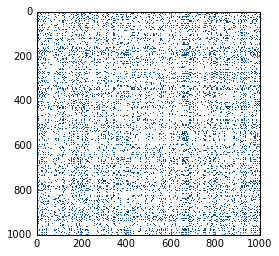

In [5]:
plt.imshow(np.log(msm.P),interpolation='none',cmap='Blues')

In [6]:
# voronoi plot
X_ = np.vstack(X)
inds = np.hstack(dtrajs)
c = inds # color by cluster ID
# c = np.array([msm.stationary_distribution[i] for i in inds]) # color by stationary distribution
# c = np.log([msm.stationary_distribution[i] for i in inds]) # color by free energy

def create_plot(centers, points, colors, cmap='Blues'):
    from scipy.spatial import Voronoi, voronoi_plot_2d
    voronoi = Voronoi(centers)
    plot = voronoi_plot_2d(voronoi, show_points=False, show_vertices=False, line_width=0.5)    
    plt.scatter(points[:,0], points[:,1], linewidths=0, c=colors, s=1, cmap=cmap)

    # axes and labels
    plt.xlabel(feat.describe()[0])
    plt.ylabel(feat.describe()[1])
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)
    plt.title('Alanine dipeptide discretized by backbone dihedrals')

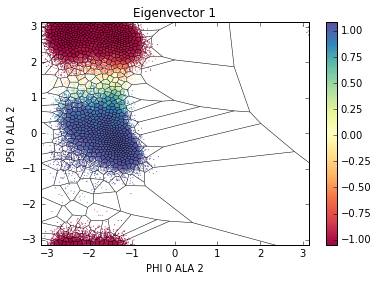

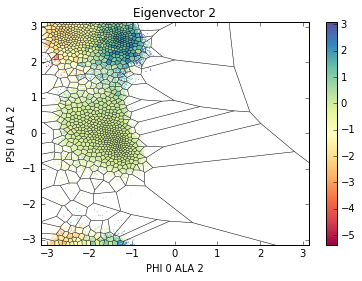

In [7]:
# plot eigenvectors
for eig in [1,2]:
    plt.figure()
    create_plot(kmeans.clustercenters, X_, [msm.eigenvectors_right()[i,eig] for i in inds], cmap='Spectral')
    plt.title('Eigenvector {0}'.format(eig))
    plt.colorbar()

In [8]:
# define functions for MCSA

def remove_worst_using_numerator(gamma, M):
    '''
    identifies i the worst trial microstate currently in M, and removes it
    
    M <-- M \ i
    
    where i is the element of M for which the probability
    is the highest that, after hitting i, the trajectory
    will hit some other target milestone j \in M before hitting i
    again
    '''
    M = list(M)
    i = np.argmax([max(gamma[i, np.array(list(set(M) - set([i])))]) for i in M])
    _ = M.pop(i)
    return set(M)

def add_best_using_denominator_term(gamma, M):
    '''
    identifies i the best trial microstate not currently in M, the denominator of metastability_index
    
    M <-- M + {i}
    '''
    l = list(set(range(len(gamma))) - set(M))
    i = np.argmin([max(gamma[i]) for i in l])
    
    return set(M).union(set([i]))

def paper_update_M(gamma, M):
    '''
    M --> {j_dagger(i) | i \in M}
    '''
    return set([np.argmax(gamma[i]) for i in M])

def robustify(proposal):
    def robustified(M):
        try: return proposal(M)
        except: return M
        
    return robustified

proposal_library_ = [lambda M:remove_worst_using_numerator(gamma, M),
                    lambda M:add_best_using_denominator_term(gamma, M),
                    lambda M:paper_update_M(gamma, M)
                   ]

proposal_library = [robustify(proposal) for proposal in proposal_library_]

def proposal_function(M):
    return np.random.choice(proposal_library)(M)

def metastability_index(gamma, M):
    '''
    possibly buggy, since this is giving infs a lot of the time
    
    numerator = max_{i \in M} (max_{j \in M \minus i} Gamma[i,j])
    denominator = min_{i \not\in M} (max_{j \in M} Gamma[i,j])
    '''
    not_M = set(range(len(gamma))) - set(M)
    M_minus = lambda i:set(M) - set([i])
    
    numerator = max([max([gamma[i,j] for j in M_minus(i) if (i != j)]) for i in M])
    denominator = min([max([gamma[i,j] for j in M if (i != j)]) for i in not_M])
    return numerator / denominator

def objective_function(M):
    try: return - metastability_index(gamma, M)
    except: return - 10000

In [9]:
from tqdm import tqdm
def estimate_gamma_version_1(dtrajs):
    '''
    iniitial implementation of estimator for Gamma
    '''
    
    dtraj_stack = np.hstack(dtrajs)
    n_states = len(set(dtraj_stack))
    
    gamma = np.zeros((n_states,n_states))
    
    for dtraj in tqdm(dtrajs):
        for i in range(n_states):
            indices = list(np.arange(len(dtraj))[dtraj==i]) + [len(dtraj)]
            for t in range(len(indices)-1):
                js = set(dtraj[indices[t]:indices[t+1]])
                for j in (js - set([i])):
                    gamma[i,j] += 1
        
    for i in range(n_states):
        gamma[i] /= np.sum(dtraj_stack==i)
    
    return gamma

In [10]:
gamma = estimate_gamma_version_1(dtrajs)

100%|██████████| 10/10 [00:41<00:00,  4.01s/it]


In [11]:
# let's try a different optimizer, incorporating the best of both worlds
import numpy as np
import numpy.random as npr

class MCSA():
   def __init__(self,
             proposal_function,
             objective_function,
             annealing_schedule):
      '''
      Monte Carlo Simulated Annealing
      
      Parameters
      ----------
      proposal_function : function
         accepts a solution object and returns a different solution object
      objective_function : function
         accepts a solution object and returns a real number
      annealing_schedule : array-like
         inverse temperature at each step of optimization
      '''
      self.proposal_function = proposal_function
      self.objective_function = objective_function
      self.annealing_schedule = annealing_schedule

   def maximize(self, init_solution, progress_bars=False):
      '''
      Maximize the objective function, given an initial solution
      Parameters
      ----------
      init_solution : object
         object that can be passed to proposal_function or objective_function
      Returns
      -------
      solutions : list of tuples
         each tuple contains:
            (solution object, objective function value)
      '''

      solutions = [(init_solution,self.objective_function(init_solution))]
    
      if progress_bars: self.annealing_schedule = tqdm(self.annealing_schedule)

      for beta in self.annealing_schedule:
         old_soln,old_f=solutions[-1]
         proposal = self.proposal_function(old_soln)
         f_proposal = self.objective_function(proposal)
         delta_Q = f_proposal - old_f
         if npr.rand() < np.exp(delta_Q * beta):
            solutions.append((proposal,f_proposal))
         else:
            solutions.append((old_soln,old_f))

      return solutions

In [12]:
n_iter = 500
annealing_schedule = np.linspace(0,10,n_iter)
mcsa = MCSA(proposal_function, objective_function, annealing_schedule)

In [13]:
def running_minimum(array): return [min(array[:i]) for i in range(1, len(array)+1)]

In [14]:
%%time
n_restarts = 100
def sample_all_but_one(): return set(np.arange(len(gamma))) - set([np.random.randint(0,len(gamma))])
starting_conditions = [sample_all_but_one() for _ in range(n_restarts)]

from multiprocessing import Pool
def maximize(init_M):
    mcsa = MCSA(proposal_function, objective_function, annealing_schedule)
    return mcsa.maximize(init_M)

p = Pool(10)
solutions = p.map(maximize, starting_conditions)
trajs = [[s[1] for s in solution] for solution in solutions]

CPU times: user 2.08 s, sys: 303 ms, total: 2.38 s
Wall time: 12min 53s


In [15]:
trajs = [-np.array(traj) for traj in trajs]

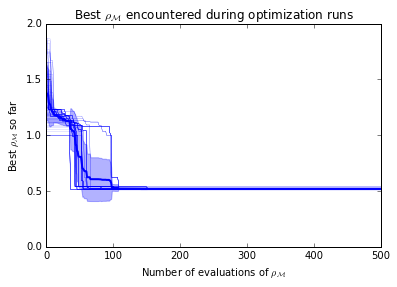

In [25]:
def plot(trajs, color='blue', label=None):
    mean = np.mean([running_minimum(traj) for traj in trajs], 0)
    stdev = np.std([running_minimum(traj) for traj in trajs], 0)

    plt.fill_between(range(len(mean)), mean - stdev, mean + stdev, alpha=0.3, color=color)
    plt.plot(mean, color=color, linewidth=2,label=label)

    for traj in trajs:
        plt.plot(running_minimum(traj), linewidth=0.1, color=color)
        
    plt.ylim(0,2)
    plt.xlabel(r'Number of evaluations of $\rho_\mathcal{M}$')
    plt.ylabel(r'Best $\rho_\mathcal{M}$ so far')
    plt.title(r'Best $\rho_\mathcal{M}$ encountered during optimization runs')
plot(trajs)

In [17]:
np.min([np.min(traj) for traj in trajs])

0.51643476507360353

In [18]:
# let's also try a softer version

def stochastic_remove_using_numerator(gamma, M):
    '''
    instead of taking the single worst i, randomly sample i
    '''
    M = list(M)
    #i = np.argmax([max(gamma[i, np.array(list(set(M) - set([i])))]) for i in M])
    p = [max(gamma[i, np.array(list(set(M) - set([i])))]) for i in M]
    i = np.random.choice(range(len(p)), p=p/sum(p))
    _ = M.pop(i)
    return set(M)

def stochastic_add_using_denominator(gamma, M):
    '''
    instead of taking the single best i, randomly sample i
    '''
    l = list(set(range(len(gamma))) - set(M))
    #i = np.argmin([max(gamma[i]) for i in l])
    p = 1.0 / np.array([max(gamma[i]) for i in l])
    i = np.random.choice(range(len(p)), p=p / sum(p))
    return set(M).union(set([i]))

In [19]:
proposal_library_ = [lambda M:stochastic_remove_using_numerator(gamma, M),
                    lambda M:stochastic_add_using_denominator(gamma, M),
                    lambda M:paper_update_M(gamma, M)
                   ]

proposal_library = [robustify(proposal) for proposal in proposal_library_]

def proposal_function(M):
    return np.random.choice(proposal_library)(M)

In [20]:
solutions = p.map(maximize, starting_conditions)
raw_trajs = [[s[1] for s in solution] for solution in solutions]

In [21]:
stoch_trajs = [-np.array(traj) for traj in raw_trajs]

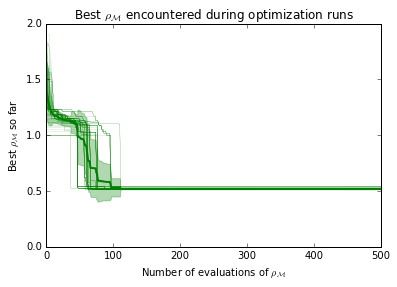

In [26]:
plot(stoch_trajs, color='green')

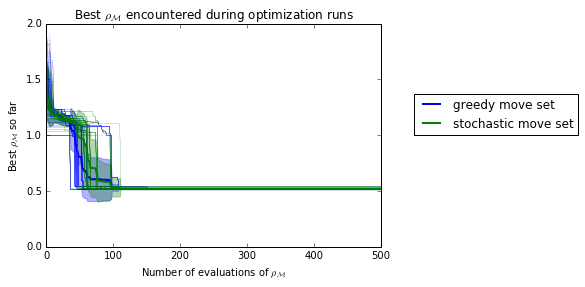

In [27]:
plot(trajs, color='blue', label='greedy move set')
plot(stoch_trajs, color='green', label='stochastic move set')
plt.legend(loc=(1.1,0.5))

(0, 100)

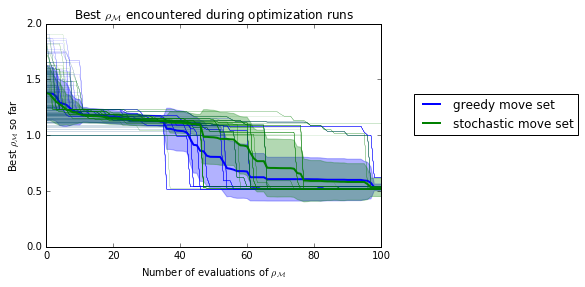

In [28]:
plot(trajs, color='blue', label='greedy move set')
plot(stoch_trajs, color='green', label='stochastic move set')
plt.legend(loc=(1.1,0.5))
plt.xlim(0,100)

In [29]:
np.min([np.min(traj) for traj in stoch_trajs])

0.51643476507360353